In [1]:
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import os
import cftime
from datetime import datetime


In [2]:
# going to pass psl file to function - will loop through a list of files and then run function

def find_psl_anomaly(ds, var, seas, output_file):
    #so far working for djf
    #checking it is a datetime object
    ds['time'] = xr.decode_cf(ds).time

    #selecting the psl (or other) variable
    variable = ds[var]

    #creating a season coordinate
    season = ds.groupby('time.season')

    #compute mean over djf - finding the djf climatology
    clim_season = season.mean(dim='time').sel(season=seas)

    #selecting just the djf months (will subract climatology from this)
    ds_months_for_seas = ds.sel(time=variable['time.season'] ==seas)

    #then need to avg over djf for each year.
    #select by year so that we can group by it
    ds_months_for_seas = ds_months_for_seas.assign_coords(year=ds_months_for_seas['time'].dt.year)

    #account for the fact that djf would be over two years, so selecting the december ones and increasing the year by 1.
    ds_months_for_seas['year'] = ds_months_for_seas['year'].where(ds_months_for_seas['time'].dt.month != 12, ds_months_for_seas['year'] + 1)

    #setting year as the corrdinate
    ds_months_for_seas = ds_months_for_seas.set_coords('year')

    #now group by the year to then calculate the mean between the months
    ds_season = ds_months_for_seas.groupby('year').mean(dim='time')

    #then subtract the climatology (clim_season)
    anomaly = ds_season - clim_season
    
    #lose the last year as it will just be december and will have been pushed to the following year.
    anomaly = anomaly.isel(year=slice(0,-1))

    anomaly.to_netcdf(output_file)

In [12]:
era5 = xr.open_dataset('/gws/nopw/j04/leader_epesc/era5/era5.194001-202406.nc')
output_file = '/gws/nopw/j04/extant/users/slbennie/psl_anomalies/era5/era5_DJF_anomalies.194001-202406.nc'
find_psl_anomaly(era5, 'msl', 'DJF', output_file)

In [18]:
era5

<xarray.Dataset> Size: 34GB
Dimensions:    (time: 1014, longitude: 1440, latitude: 721)
Coordinates:
  * time       (time) datetime64[ns] 8kB 1940-01-01 1940-02-01 ... 2024-06-01
  * longitude  (longitude) float32 6kB 0.0 0.25 0.5 0.75 ... 359.2 359.5 359.8
  * latitude   (latitude) float32 3kB 90.0 89.75 89.5 ... -89.5 -89.75 -90.0
Data variables:
    t2m        (time, latitude, longitude) float64 8GB ...
    msl        (time, latitude, longitude) float64 8GB ...
    sst        (time, latitude, longitude) float64 8GB ...
    tp         (time, latitude, longitude) float64 8GB ...
Attributes:
    CDI:          Climate Data Interface version 2.4.0 (https://mpimet.mpg.de...
    Conventions:  CF-1.6
    history:      Wed Jul 31 08:59:15 2024: cdo --reduce_dim -copy era5_expve...
    CDO:          Climate Data Operators version 2.4.0 (https://mpimet.mpg.de...

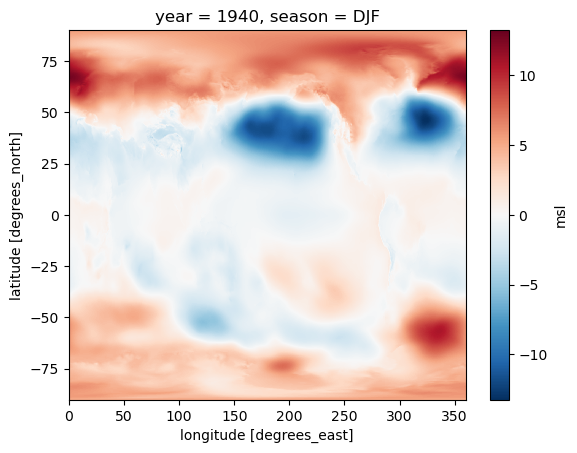

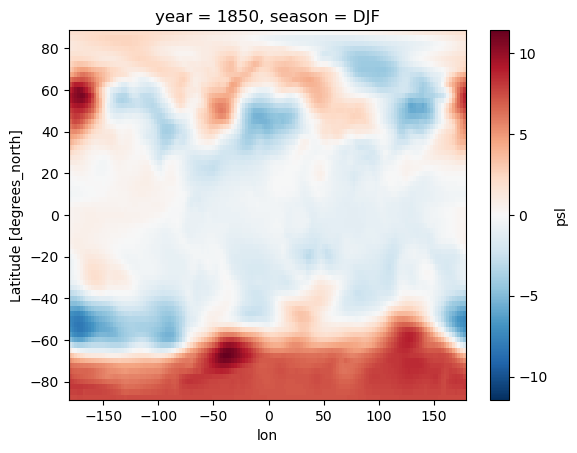

In [6]:
output_file = '/gws/nopw/j04/extant/users/slbennie/psl_anomalies/era5/era5_DJF_anomalies.194001-202406.nc'
ds = xr.open_dataset(output_file)
ds['msl']
((ds['msl'].isel(year=0))/100).plot()
plt.show()

ds = xr.open_dataset('/gws/nopw/j04/extant/users/slbennie/psl_anomalies/historical/HadGEM3-GC31-LL/psl_mon_historical_HadGEM3-GC31-LL_r21i1p1f3_DJF_anomaly.nc')
((ds['psl'].isel(year=0))/100).plot()
plt.show()

In [3]:
#setting up to loop through all HadGem3 historical and for djf
#variable = 'psl'
#season = 'DJF'
#model = 'HadGEM3-GC31-LL'
#folderpath = '/gws/nopw/j04/leader_epesc/CMIP6_SinglForcHistSimul/InterpolatedFlds/psl/historical/HadGEM3-GC31-LL/'

#find files and put into list
#ens_files = [os.path.join(folderpath, filename) for filename in os.listdir(folderpath) if model in filename]

#loop through each file in ens_files
#for i in range(0,len(ens_files)):
#    ds = xr.open_dataset(ens_files[i])

    #create output filename by creating a path to extant gws instead/
#    output_file = ens_files[i].replace('interp.nc', season+'_anomaly.nc')
#    output_file = output_file.replace('leader_epesc/CMIP6_SinglForcHistSimul/InterpolatedFlds/psl/','extant/users/slbennie/psl_anomalies/')
    #print(output_file)

    #find the anomaly - will save it to a net cdf
#    find_psl_anomaly(ds,variable,season,output_file)

In [5]:
#setting up to loop through all HadGem3 historical and for djf
def get_time_bounds(calendar_type):
    #selects the right datetime object to get correct time slice
    #manually set 1850-2015/2014 depending on data type.
    #could add inputs as the start and end years to make easier to loop through at some point
    if calendar_type == cftime.DatetimeNoLeap:
        return cftime.DatetimeNoLeap(1850,1,16), cftime.DatetimeNoLeap(2015,1,16)
    elif calendar_type == cftime.Datetime360Day:
        return cftime.Datetime360Day(1850,1,16), cftime.Datetime360Day(2014,12,16)
    else:
        return datetime(1850,1,16), datetime(2015,1,16)

def get_models_for_experiment(experiment):
    #finds the list of models for a given experiment
    if experiment == 'historical':
        model = ['ACCESS-ESM1-5','CanESM5','CMCC-CM2-SR5','FGOALS-g3','GISS-E2-1-G','HadGEM3-GC31-LL','IPSL-CM6A-LR','MIROC6','MPI-ESM1-2-LR','NorESM2-LM']
    elif experiment == 'hist-aer':
        model = ['ACCESS-ESM1-5','CanESM5','CMCC-CM2-SR5','CNRM-CM6-1','FGOALS-g3','GISS-E2-1-G','HadGEM3-GC31-LL','IPSL-CM6A-LR','MIROC6','MPI-ESM1-2-LR','NorESM2-LM']
    elif experiment == 'hist-GHG':
        model = ['ACCESS-ESM1-5','CanESM5','CMCC-CM2-SR5','CNRM-CM6-1','FGOALS-g3','GISS-E2-1-G','HadGEM3-GC31-LL','IPSL-CM6A-LR','MIROC6','MPI-ESM1-2-LR','NorESM2-LM']
    elif experiment == 'hist-sol':
        model = ['ACCESS-ESM1-5','CanESM5','GISS-E2-1-G','HadGEM3-GC31-LL','MIROC6','MPI-ESM1-2-LR','NorESM2-LM']
    elif experiment == 'hist-totalO3':
        model = ['CanESM5','GISS-E2-1-G','HadGEM3-GC31-LL','MIROC6','MPI-ESM1-2-LR','NorESM2-LM']
    elif experiment == 'hist-volc':
        model = ['ACCESS-ESM1-5','CanESM5','CMCC-CM2-SR5','GISS-E2-1-G','HadGEM3-GC31-LL','MIROC6','MPI-ESM1-2-LR','NorESM2-LM']
    return model



In [ ]:
#list of experiments to run through
experiment = ['historical']#,'hist-aer', 'hist-GHG', 'hist-sol', 'hist-totalO3', 'hist-volc']

for e in experiment:
    #loop through each experiment
    print('Calculating the psl anomalies for experiment: ', e)
    #creating a file to log the time periods for each ensemble member, new file per experiment
    log_file = 'time_check/'+ e +'_time_check.txt'
    
    variable = 'psl'
    season = 'DJF'
    period = (2015-1850)*12    

    #getting the list of models for each experiment
    model = ['HadGEM3-GC31-LL']
    
    with open(log_file, 'w') as f:
        #loop through each model
        for m in model:
            print('Model:', m)
            
            #assigning folder path
            folder_path = '/gws/nopw/j04/leader_epesc/CMIP6_SinglForcHistSimul/InterpolatedFlds/psl/'+e+'/'+m+'/'
            
            #find files and put into list
            ens_files = [os.path.join(folder_path, filename) for filename in os.listdir(folder_path) if m in filename if 'r5i1p1f3' in filename]
    
            #writing model name to log file and number of ensembles
            number_ens = len(ens_files)
            f.write(f"\nModel: {m},   Number of Ensembles: {number_ens}\n")
            ens_discard = 0
            
            #loop through each file in ens_files (looping through each ensemble for this model and experiment)
            for i in range(0,len(ens_files)):
                with xr.open_dataset(ens_files[i]) as ds:
                    #finding the calendar type - all are a little bit different
                    calendar_type = type(ds.time.values[0])
                    
                    #calls function to get the appropriate datetime/cftime variables based on the calendar type
                    year_init, year_final = get_time_bounds(calendar_type)
    
                    #slices the data to the required years
                    ds_slice = ds.sel(time=slice(year_init, year_final))
    
                    #noting down the first and last time values as well as the number of values inbetween them for future reference and the calendar type for each model
                    log_line = f"{os.path.basename(ens_files[i])} with calendar: {calendar_type}, {ds['time'].values[0]} to {ds['time'].values[-1]}, {len(ds['time'])} time steps\n"
                    f.write(log_line)

                    if len(ds_slice[variable]) < period:
                        #skipping any files that don't have all the data between 1850 and 2015.
                        #would still calculate the seasonal anomaly for files that cover this period and more (none are longer than this anyways)
                        #but will discard any that fail to cover at least 1850-2014
                        ens_discard = ens_discard + 1
                        continue
                
                    #create output filename by creating a path to extant gws instead/
                    output_file = ens_files[i].replace('interp.nc', season+'_anomaly.nc')
                    output_file = output_file.replace('leader_epesc/CMIP6_SinglForcHistSimul/InterpolatedFlds/psl/','extant/users/slbennie/psl_anomalies/')
                
                    #find the anomaly - will save it to a net cdf
                    find_psl_anomaly(ds,variable,season,output_file)
            
            #noting how many ensembles have been discarded for each model.
            f.write(f"Number of ensembles discarded as times did not cover the period of at least 1850-2015: {ens_discard}, Ensembles left: {number_ens-ens_discard}\n")


In [28]:
ds_anomaly = xr.open_dataset('/gws/nopw/j04/extant/users/slbennie/psl_anomalies/historical/NorESM2-LM/psl_mon_historical_NorESM2-LM_r11i1p1f1_DJF_anomaly.nc')
ds_anomaly

<xarray.Dataset> Size: 15MB
Dimensions:   (lat: 71, lon: 144, year: 171, bnds: 2)
Coordinates:
  * lat       (lat) float64 568B -87.5 -85.0 -82.5 -80.0 ... 80.0 82.5 85.0 87.5
  * lon       (lon) float64 1kB -180.0 -177.5 -175.0 ... 172.5 175.0 177.5
  * year      (year) int64 1kB 1850 1851 1852 1853 1854 ... 2017 2018 2019 2020
    season    <U3 12B ...
Dimensions without coordinates: bnds
Data variables:
    lat_bnds  (year, lat, bnds) float64 194kB ...
    lon_bnds  (year, lon, bnds) float64 394kB ...
    psl       (year, lat, lon) float64 14MB ...

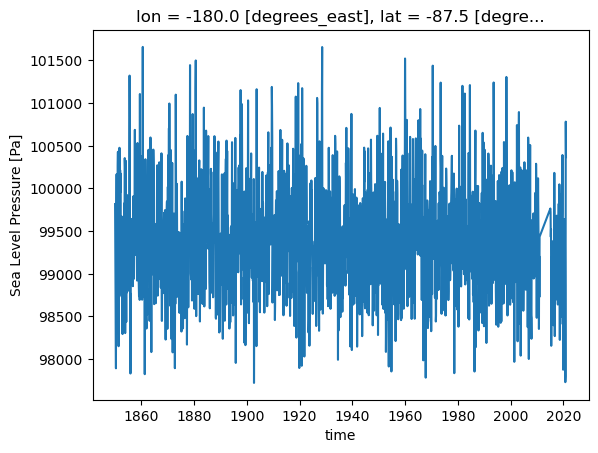

In [67]:
ds = xr.open_dataset('/gws/nopw/j04/leader_epesc/incoming/Amon/psl/hist-aer/ACCESS-ESM1-5/psl_mon_hist-aer_ACCESS-ESM1-5_r7i1p1f1_interp.nc')
ds['psl'].isel(lat=0, lon=0).plot()

In [4]:
def CVDP_EM_crop_NA_sector(filename, pattern):
    #function which will crop the historical ensemble mean CVDP output to the NA sector
    ds = xr.open_dataset(filename)
    print(ds)
    ds = ds[pattern]
    
    # finding the longitudes that are greater than 180
    new_lon = np.where(ds.lon > 179, ds.lon - 360, ds.lon)
    
    # Assign new longitude values using the correctly named variable
    ds = ds.assign_coords(lon=new_lon)

    # Sort longitudes and select NA sector
    ds = ds.sortby('lon')
    ds = ds.sortby('lat')
    ds_cropped = ds.sel(lat=slice(20, 80), lon=slice(-90, 40))

    return ds_cropped


    

In [2]:
output_file = '/gws/nopw/j04/extant/users/slbennie/psl_anomalies/era5/era5_DJF_anomalies.194001-202406.nc'
era5 = xr.open_dataset(output_file)
era5 = era5.rename({'longitude': 'lon'})
era5 = era5.rename({'latitude': 'lat'})
era5 = era5.rename({'msl': 'psl'})
output_file = output_file.replace('.194001-202406', '_renamed_coords')
era5.to_netcdf(output_file)


In [5]:
output_file = '/gws/nopw/j04/extant/users/slbennie/psl_anomalies/era5/era5_DJF_anomalies_renamed_coords.nc'
shifted = CVDP_EM_crop_NA_sector(output_file, 'psl')
output_file = output_file.replace('renamed_coords', '1940-2024')
shifted
print(shifted['lat'])
print(shifted['lat'].dtype)
print(shifted['lat'].values)
print(shifted['lat'].attrs)
print(np.any(np.diff(shifted['lat'].values) <= 0))  # should be False
print(np.any(np.diff(shifted['lon'].values) <= 0))  # should be False

shifted.to_netcdf(output_file)

<xarray.Dataset> Size: 3GB
Dimensions:  (lon: 1440, lat: 721, year: 84)
Coordinates:
  * lon      (lon) float32 6kB 0.0 0.25 0.5 0.75 1.0 ... 359.0 359.2 359.5 359.8
  * lat      (lat) float32 3kB 90.0 89.75 89.5 89.25 ... -89.5 -89.75 -90.0
  * year     (year) int64 672B 1940 1941 1942 1943 1944 ... 2020 2021 2022 2023
    season   <U3 12B ...
Data variables:
    t2m      (year, lat, lon) float64 698MB ...
    psl      (year, lat, lon) float64 698MB ...
    sst      (year, lat, lon) float64 698MB ...
    tp       (year, lat, lon) float64 698MB ...
<xarray.DataArray 'lat' (lat: 241)> Size: 964B
array([20.  , 20.25, 20.5 , ..., 79.5 , 79.75, 80.  ], dtype=float32)
Coordinates:
  * lat      (lat) float32 964B 20.0 20.25 20.5 20.75 ... 79.25 79.5 79.75 80.0
    season   <U3 12B ...
Attributes:
    standard_name:  latitude
    long_name:      latitude
    units:          degrees_north
    axis:           Y
float32
[20.   20.25 20.5  20.75 21.   21.25 21.5  21.75 22.   22.25 22.5  22.75
 23

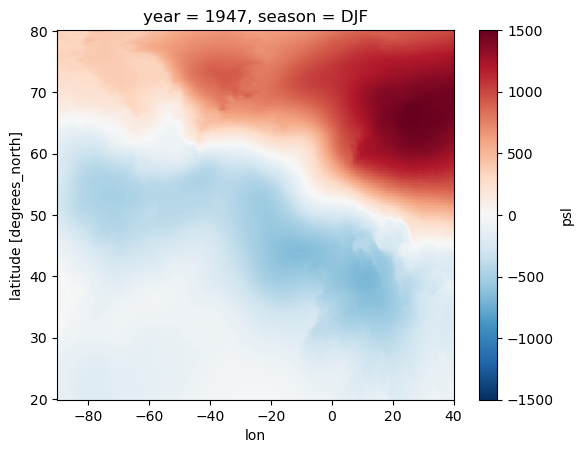

In [6]:
era5 = xr.open_dataset(output_file)
era5['psl'].isel(year=7).plot()
plt.show()